In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jax import lax
from jax import scipy as jscipy

import numpyro
import numpyro.distributions as dist
import numpyro.infer.kernels as kernels
from numpyro.distributions import constraints
from numpyro.infer import ELBO, Stein
from numpyro.infer.autoguide import AutoDelta
from numpyro.infer.initialization import init_to_value, init_with_noise
from numpyro.callbacks import Progbar
from numpyro.optim import Adagrad

In [2]:
rng_key = jax.random.PRNGKey(42)

# Sine Model

In [3]:
class Sine(dist.Distribution):
    support = constraints.real
    def __init__(self, alpha=jnp.array(1.), sigma1=jnp.array(3e-3), sigma2=jnp.array(1.0), validate_args=None):
        batch_shape = lax.broadcast_shapes(jnp.shape(alpha), jnp.shape(sigma1), jnp.shape(sigma2))
        self.alpha = jnp.broadcast_to(alpha, batch_shape)
        self.sigma1 = jnp.broadcast_to(sigma1, batch_shape)
        self.sigma2 = jnp.broadcast_to(sigma2, batch_shape)
        super(Sine, self).__init__(batch_shape=batch_shape, validate_args=validate_args)

    def log_prob(self, value):
        return jnp.where(jnp.logical_and(jnp.all(-1 <= value, axis=-1), jnp.all(value <= 1, axis=-1)),
                        - (value[..., 1] + jnp.sin(self.alpha * value[..., 0])) ** 2 / (2 * self.sigma1) -
                          (value[..., 0] ** 2 + value[..., 1] ** 2) / (2 * self.sigma2),
                        -10e3)

    def sample(self, key, sample_shape=()):
        xs = jnp.array(np.linspace(-1, 1, num=100))
        ys = jnp.array(np.linspace(-1, 1, num=100))
        zs = jnp.stack(jnp.meshgrid(xs, ys), axis=-1)
        logits = jnp.expand_dims(jnp.ravel(self.log_prob(zs)), axis=0)
        cs = dist.Categorical(logits=logits).sample(key, sample_shape)
        res = jnp.concatenate(jnp.divmod(cs, zs.shape[0]), axis=-1).astype('float') /\
              jnp.array([jnp.max(xs) - jnp.min(xs), jnp.max(ys) - jnp.min(ys)]) + jnp.array([jnp.min(xs), jnp.min(ys)])
        return res

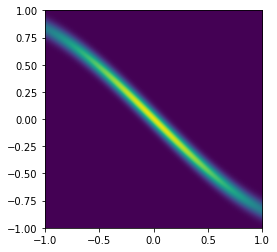

In [4]:
sine_xs = np.linspace(-1, 1, num=100)
sine_ys = np.linspace(-1, 1, num=100)
sine_zs = np.stack(np.meshgrid(sine_xs, sine_ys), axis=-1)
sine_lps = np.exp(Sine().log_prob(sine_zs))
plt.imshow(sine_lps, origin='lower', interpolation='bicubic', extent=[np.min(sine_xs), np.max(sine_xs), 
                                                                      np.min(sine_ys), np.max(sine_ys)])
plt.show()

In [5]:
num_iterations = 30

In [6]:
def model():
    numpyro.sample('x', Sine())
guide = AutoDelta(model, init_strategy=init_with_noise(init_to_value(values={'x': jnp.array([0., 0.])}), noise_scale=1.0))

In [7]:
svgd = Stein(model, guide, Adagrad(step_size=0.1), ELBO(),
             kernels.RBFKernel(), num_particles=50)

/usr/local/Caskroom/miniconda/base/envs/numpyro-stein/lib/python3.8/site-packages/jax/lax/lax.py:5605: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
Stein 3205.0: 100%|██████████| 30/30 [00:00<00:00, 42.77it/s]


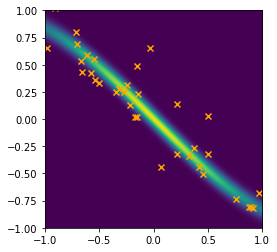

In [8]:
svgd_state, loss = svgd.train(rng_key, num_iterations, callbacks=[Progbar()])
res = svgd.get_params(svgd_state)['auto_x']
plt.clf()
plt.imshow(sine_lps, origin='lower', interpolation='bicubic', extent=[np.min(sine_xs), np.max(sine_xs), 
                                                                      np.min(sine_ys), np.max(sine_ys)])
plt.scatter(res[..., 0], res[..., 1], c='orange', marker='x')
plt.xlim((np.min(sine_xs), np.max(sine_xs)))
plt.ylim((np.min(sine_ys), np.max(sine_ys)))
plt.show()

In [9]:
svgd = Stein(model, guide, Adagrad(step_size=0.1), ELBO(),
             kernels.PrecondMatrixKernel(kernels.HessianPrecondMatrix(), kernels.RBFKernel(mode='matrix'),
                                        precond_mode='const'),
            num_particles=50)

Stein 3003.8: 100%|██████████| 30/30 [00:01<00:00, 22.27it/s]


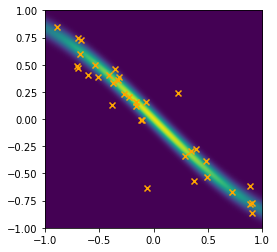

In [10]:
svgd_state, loss = svgd.train(rng_key, num_iterations, callbacks=[Progbar()])
res = svgd.get_params(svgd_state)['auto_x']
plt.clf()
plt.imshow(sine_lps, origin='lower', interpolation='bicubic', extent=[np.min(sine_xs), np.max(sine_xs), 
                                                                      np.min(sine_ys), np.max(sine_ys)])
plt.scatter(res[..., 0], res[..., 1], c='orange', marker='x')
plt.xlim((np.min(sine_xs), np.max(sine_xs)))
plt.ylim((np.min(sine_ys), np.max(sine_ys)))
plt.show()

In [11]:
svgd = Stein(model, guide, Adagrad(step_size=0.5), ELBO(),
             kernels.PrecondMatrixKernel(kernels.HessianPrecondMatrix(), kernels.RBFKernel(mode='matrix'),
                                        precond_mode='anchor_points'),
             num_particles=50)

Stein 4608.9: 100%|██████████| 30/30 [00:03<00:00,  8.56it/s]


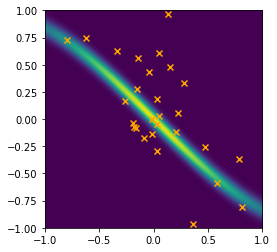

In [12]:
svgd_state, loss = svgd.train(rng_key, num_iterations, callbacks=[Progbar()])
res = svgd.get_params(svgd_state)['auto_x']
plt.clf()
plt.imshow(sine_lps, origin='lower', interpolation='bicubic', extent=[np.min(sine_xs), np.max(sine_xs), 
                                                                      np.min(sine_ys), np.max(sine_ys)])
plt.scatter(res[..., 0], res[..., 1], c='orange', marker='x')
plt.xlim((np.min(sine_xs), np.max(sine_xs)))
plt.ylim((np.min(sine_ys), np.max(sine_ys)))
plt.show()

# Double Banana Model

In [13]:
class DoubleBanana(dist.Distribution):
    support = constraints.real
    def __init__(self, y=jnp.log(30.), sigma1=jnp.array(1.0), sigma2=jnp.array(9e-2), validate_args=None):
        batch_shape = lax.broadcast_shapes(jnp.shape(y), jnp.shape(sigma1), jnp.shape(sigma2))
        self.y = jnp.broadcast_to(y, batch_shape)
        self.sigma1 = jnp.broadcast_to(sigma1, batch_shape)
        self.sigma2 = jnp.broadcast_to(sigma2, batch_shape)
        super(DoubleBanana, self).__init__(batch_shape=batch_shape, validate_args=validate_args)
    
    def log_prob(self, value):
        fx = jnp.log((1 - value[..., 0]) ** 2.0 + 100 * (value[..., 1] - value[..., 0] ** 2.0) ** 2.0)
        return - jnp.sqrt(value[..., 0] ** 2.0 + value[..., 1] ** 2.0) ** 2.0 / (2.0 * self.sigma1) -\
                 (self.y - fx) ** 2.0 / (2.0 * self.sigma2)

    
    def sample(self, key, sample_shape=()):
        xs = jnp.array(np.linspace(-1.5, 1.5, num=100))
        ys = jnp.array(np.linspace(-1, 2, num=100))
        zs = jnp.stack(jnp.meshgrid(xs, ys), axis=-1)
        logits = jnp.expand_dims(jnp.ravel(self.log_prob(zs)), axis=0)
        cs = dist.Categorical(logits=logits).sample(key, sample_shape)
        res = jnp.concatenate(jnp.divmod(cs, zs.shape[0]), axis=-1).astype('float') /\
              jnp.array([jnp.max(xs) - jnp.min(xs), jnp.max(ys) - jnp.min(ys)]) + jnp.array([jnp.min(xs), jnp.min(ys)])
        return res

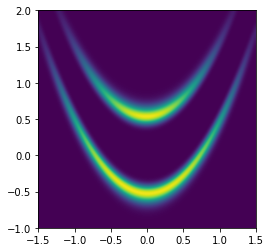

In [14]:
db_xs = np.linspace(-1.5, 1.5, num=100)
db_ys = np.linspace(-1, 2, num=100)
db_zs = np.stack(np.meshgrid(db_xs, db_ys), axis=-1)
db_lps = np.exp(DoubleBanana().log_prob(db_zs))
plt.imshow(db_lps, origin='lower', interpolation='bicubic', extent=[np.min(db_xs), np.max(db_xs), 
                                                                    np.min(db_ys), np.max(db_ys)])
plt.show()

In [15]:
num_iterations = 100

In [16]:
def model():
    numpyro.sample('x', DoubleBanana())
guide = AutoDelta(model, init_strategy=init_with_noise(init_to_value(values={'x': jnp.array([0., 0.])}), noise_scale=3.0))

In [17]:
svgd = Stein(model, guide, Adagrad(step_size=1.0), ELBO(),
             kernels.RBFKernel(), num_particles=50)

Stein 8.6142: 100%|██████████| 100/100 [00:00<00:00, 150.06it/s]


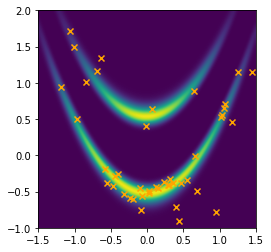

In [18]:
svgd_state, loss = svgd.train(rng_key, num_iterations, callbacks=[Progbar()])
res = svgd.get_params(svgd_state)['auto_x']
plt.clf()
plt.imshow(db_lps, origin='lower', interpolation='bicubic', extent=[np.min(db_xs), np.max(db_xs), 
                                                                    np.min(db_ys), np.max(db_ys)])
plt.scatter(res[..., 0], res[..., 1], c='orange', marker='x')
plt.xlim((np.min(db_xs), np.max(db_xs)))
plt.ylim((np.min(db_ys), np.max(db_ys)))
plt.show()

In [19]:
svgd = Stein(model, guide, Adagrad(step_size=1.0), ELBO(),
             kernels.PrecondMatrixKernel(kernels.HessianPrecondMatrix(), kernels.RBFKernel(mode='matrix'),
                                        precond_mode='const'),
             num_particles=50)

Stein 2.7604: 100%|██████████| 100/100 [00:01<00:00, 68.26it/s]


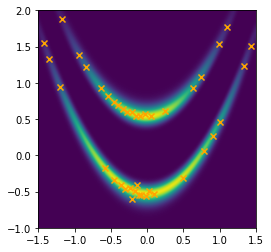

In [20]:
svgd_state, loss = svgd.train(rng_key, num_iterations, callbacks=[Progbar()])
res = svgd.get_params(svgd_state)['auto_x']
plt.imshow(db_lps, origin='lower', interpolation='bicubic', extent=[np.min(db_xs), np.max(db_xs), 
                                                                    np.min(db_ys), np.max(db_ys)])
plt.scatter(res[..., 0], res[..., 1], c='orange', marker='x')
plt.xlim((np.min(db_xs), np.max(db_xs)))
plt.ylim((np.min(db_ys), np.max(db_ys)))
plt.show()

In [21]:
svgd = Stein(model, guide, Adagrad(step_size=.8), ELBO(),
             kernels.PrecondMatrixKernel(kernels.HessianPrecondMatrix(), kernels.RBFKernel(mode='matrix'),
                                        precond_mode='anchor_points'),
             num_particles=50)

Stein 70.8: 100%|██████████| 100/100 [00:05<00:00, 18.45it/s] 


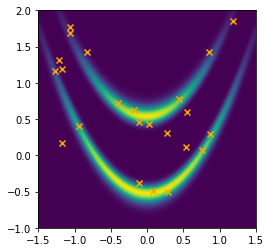

In [22]:
svgd_state, loss = svgd.train(rng_key, num_iterations, callbacks=[Progbar()])
res = svgd.get_params(svgd_state)['auto_x']
plt.imshow(db_lps, origin='lower', interpolation='bicubic', extent=[np.min(db_xs), np.max(db_xs), 
                                                                    np.min(db_ys), np.max(db_ys)])
plt.scatter(res[..., 0], res[..., 1], c='orange', marker='x')
plt.xlim((np.min(db_xs), np.max(db_xs)))
plt.ylim((np.min(db_ys), np.max(db_ys)))
plt.show()

# Star Model

In [23]:
class Star(dist.Distribution):
    support = constraints.real
    def __init__(self, mu0=jnp.array([0., 1.5]), cov0=jnp.diag(jnp.array([1e-2, 0.25])), n_comp=5, validate_args=None):
        batch_shape = lax.broadcast_shapes(jnp.shape(mu0)[:-1], jnp.shape(cov0)[:-2])
        mu0 = jnp.broadcast_to(mu0, batch_shape + jnp.shape(mu0)[-1:])
        cov0 = jnp.broadcast_to(cov0, batch_shape + jnp.shape(cov0)[-2:])
        self.n_comp = n_comp
        mus = [mu0]
        covs = [cov0]
        theta = 2 * jnp.pi / n_comp
        rot = jnp.array([[jnp.cos(theta), -jnp.sin(theta)], [jnp.sin(theta), jnp.cos(theta)]])
        for i in range(n_comp - 1):
            mui = rot @ mus[-1]
            covi = rot @ covs[-1] @ rot.transpose()
            mus.append(mui)
            covs.append(covi)
        self.mus = jnp.stack(mus)
        self.covs = jnp.stack(covs)
        super(Star, self).__init__(batch_shape=batch_shape, validate_args=validate_args)
    
    def log_prob(self, value):
        lps = []
        for i in range(self.n_comp):
            lps.append(dist.MultivariateNormal(self.mus[i], self.covs[i]).log_prob(value))
        return jscipy.special.logsumexp(jnp.stack(lps, axis=0), axis=0) / self.n_comp

    def sample(self, key, sample_shape=()):
        zs = dist.Categorical(probs=jnp.array([1/self.n_comp] * self.n_comp)).sample(key, sample_shape)
        xs = jnp.stack([dist.MultivariateNormal(self.mus[i], self.covs[i]).sample(key, sample_shape) 
                       for i in range(self.n_comp)], axis=0)
        return jnp.take_along_axis(xs, jnp.expand_dims(jnp.expand_dims(zs, axis=-1), axis=-1), axis=0)

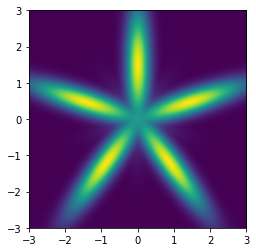

In [24]:
star_xs = np.linspace(-3, 3, num=100)
star_ys = np.linspace(-3, 3, num=100)
star_zs = np.stack(np.meshgrid(star_xs, star_ys), axis=-1)
star_lps = np.exp(Star().log_prob(star_zs))
plt.imshow(star_lps, origin='lower', interpolation='bicubic', extent=[np.min(star_xs), np.max(star_xs),
                                                                      np.min(star_ys), np.max(star_ys)])
plt.show()

In [25]:
num_iterations = 60

In [26]:
def model():
    numpyro.sample('x', Star())
guide = AutoDelta(model, init_strategy=init_with_noise(init_to_value(values={'x': np.array([[0., 0.]])}), noise_scale=3.0))

In [27]:
svgd = Stein(model, guide, Adagrad(step_size=1.0), ELBO(),
             kernels.RBFKernel(), num_particles=50)

Stein 0.71883: 100%|██████████| 60/60 [00:00<00:00, 60.28it/s]


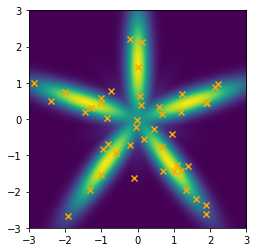

In [28]:
svgd_state, loss = svgd.train(rng_key, num_iterations, callbacks=[Progbar()])
res = svgd.get_params(svgd_state)['auto_x']
plt.clf()
plt.imshow(star_lps, origin='lower', interpolation='bicubic', extent=[np.min(star_xs), np.max(star_xs), 
                                                                      np.min(star_ys), np.max(star_ys)])
plt.scatter(res[..., 0], res[..., 1], c='orange', marker='x')
plt.xlim((np.min(star_xs), np.max(star_xs)))
plt.ylim((np.min(star_ys), np.max(star_ys)))
plt.show()

In [29]:
svgd = Stein(model, guide, Adagrad(step_size=0.5), ELBO(),
             kernels.PrecondMatrixKernel(kernels.HessianPrecondMatrix(), kernels.RBFKernel(mode='matrix'),
                                         precond_mode='const'),
             num_particles=50)

Stein 1.8955: 100%|██████████| 60/60 [00:02<00:00, 20.26it/s]


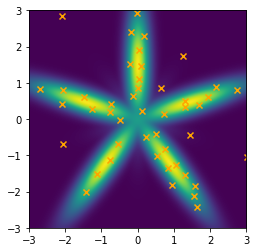

In [30]:
svgd_state, loss = svgd.train(rng_key, num_iterations, callbacks=[Progbar()])
res = svgd.get_params(svgd_state)['auto_x']
plt.clf()
plt.imshow(star_lps, origin='lower', interpolation='bicubic', extent=[np.min(star_xs), np.max(star_xs), 
                                                                      np.min(star_ys), np.max(star_ys)])
plt.scatter(res[..., 0], res[..., 1], c='orange', marker='x')
plt.xlim((np.min(star_xs), np.max(star_xs)))
plt.ylim((np.min(star_ys), np.max(star_ys)))
plt.show()

In [31]:
svgd = Stein(model, guide, Adagrad(step_size=0.8), ELBO(),
             kernels.PrecondMatrixKernel(kernels.HessianPrecondMatrix(), kernels.RBFKernel(mode='matrix'),
                                         precond_mode='anchor_points'),
             num_particles=50)

Stein 0.65201: 100%|██████████| 60/60 [00:05<00:00, 11.47it/s]


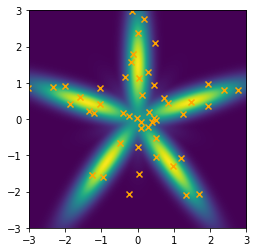

In [32]:
svgd_state, loss = svgd.train(rng_key, num_iterations, callbacks=[Progbar()])
res = svgd.get_params(svgd_state)['auto_x']
plt.clf()
plt.imshow(star_lps, origin='lower', interpolation='bicubic', extent=[np.min(star_xs), np.max(star_xs), 
                                                                      np.min(star_ys), np.max(star_ys)])
plt.scatter(res[..., 0], res[..., 1], c='orange', marker='x')
plt.xlim((np.min(star_xs), np.max(star_xs)))
plt.ylim((np.min(star_ys), np.max(star_ys)))
plt.show()

In [33]:
svgd = Stein(model, guide, Adagrad(step_size=0.8), ELBO(),
             kernels.RBFKernel(),
             num_particles=50,
             num_mcmc_particles=5, sp_mode='global',
             num_mcmc_updates=100)

Stein 10.084: 100%|██████████| 60/60 [00:18<00:00,  3.29it/s]


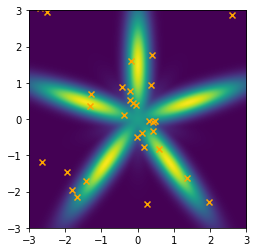

In [34]:
svgd_state, loss = svgd.train(rng_key, num_iterations, callbacks=[Progbar()])
res = svgd.get_params(svgd_state)['auto_x']
plt.clf()
plt.imshow(star_lps, origin='lower', interpolation='bicubic', extent=[np.min(star_xs), np.max(star_xs), 
                                                                      np.min(star_ys), np.max(star_ys)])
plt.scatter(res[..., 0], res[..., 1], c='orange', marker='x')
plt.xlim((np.min(star_xs), np.max(star_xs)))
plt.ylim((np.min(star_ys), np.max(star_ys)))
plt.show()